# Under-represented Class Training Notebook

Edit `CONFIG` cell before training.

In [6]:
!pip install -q --upgrade pip
!pip install -q ultralytics
import ultralytics, torch
print('ultralytics', ultralytics.__version__)
print('torch', torch.__version__)
!pip install plotly --quiet
import plotly.graph_objects as go
import pandas as pd
from pathlib import Path


ultralytics 8.3.232
torch 2.9.1+cpu


In [12]:
DATASET_ROOT = 'datasets/train_dataset'
DATA_YAML = f"{DATASET_ROOT}/dataset.yaml"
NUM_EPOCHS = 20
MODEL = 'yolov8n.pt'
BATCH = 16
IMG_SIZE = 512
DEVICE = 'cpu'
DO_TRAIN = True


DATASET_ROOT: D:\ThisPC\Documents\Unity Projects\synthetic-vision-training-pipeline\2. SOTA Training\datasets\train_dataset
images/train exists: True
images found: 951


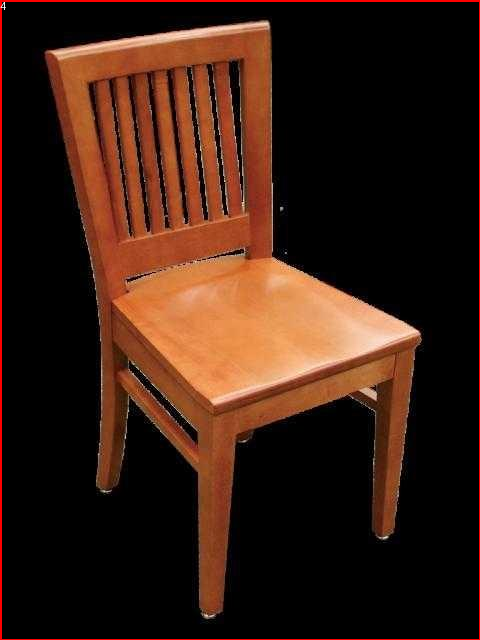

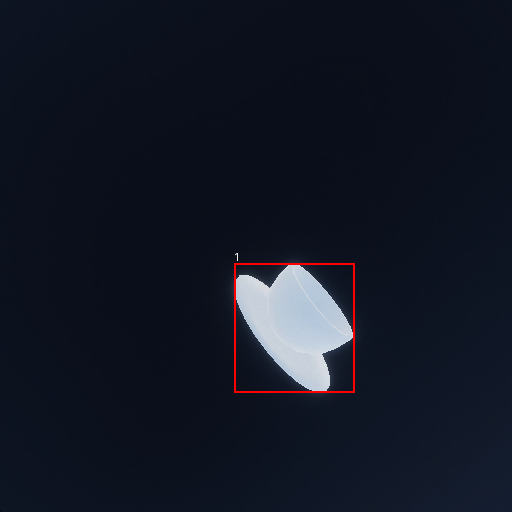

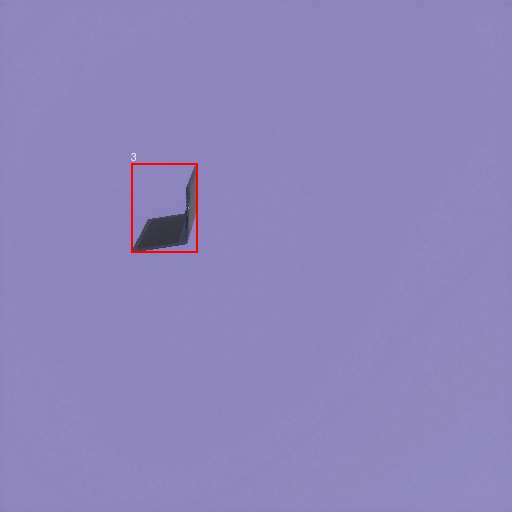

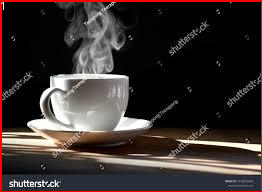

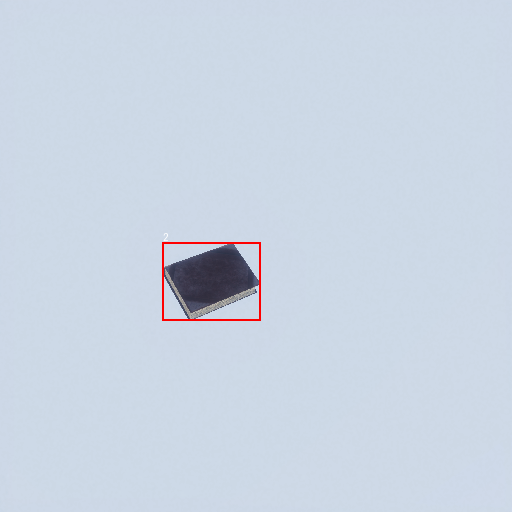

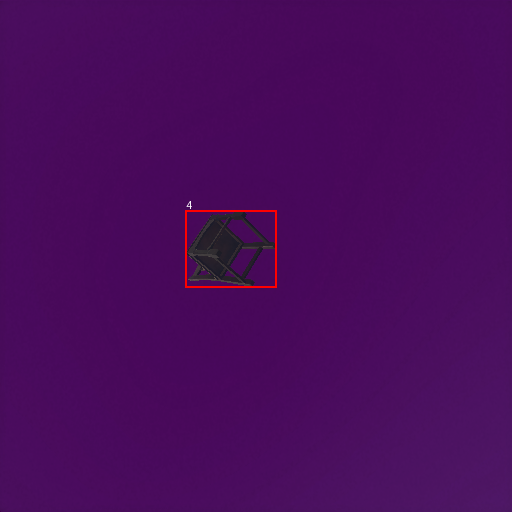

In [14]:
#!/usr/bin/env python3
"""
Notebook-friendly YOLO dataset sanity-check (fixed path handling).
Run in IPython/Jupyter where DATASET_ROOT is defined.
"""

from pathlib import Path
from PIL import Image, ImageDraw
from IPython.display import display
import random
import os

# -------------------------
# Helpers
# -------------------------
VALID_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}


def resolve_dataset_root(raw_root) -> Path:
    """
    Accept a Path-like value (DATASET_ROOT). Fix accidental ".../src/src/..." duplication
    using a simple literal replacement (no regex). Return an absolute Path.
    """
    if raw_root is None:
        raise ValueError("DATASET_ROOT is not defined or is None.")
    p = Path(raw_root)
    # Replace any occurrence of 'src/src' with a single 'src' using os.path.join so separators are correct.
    double_src = os.path.join("src", "src")
    single_src = os.path.join("src")
    fixed_str = str(p).replace(double_src, single_src)
    return Path(fixed_str).resolve()


def collect_image_files(images_folder: Path) -> list[Path]:
    """
    Collect image files from images_folder (non-recursive first, then recursive).
    Raises if none found.
    """
    if not images_folder.exists():
        raise FileNotFoundError(images_folder)
    files = [p for p in images_folder.iterdir() if p.suffix.lower() in VALID_EXTS and p.is_file()]
    if not files:
        files = [p for p in images_folder.rglob("*") if p.suffix.lower() in VALID_EXTS and p.is_file()]
    if not files:
        raise RuntimeError(f"No images found under {images_folder}")
    return sorted(files)


def parse_label_file(label_path: Path) -> list[tuple]:
    """
    Read a YOLO label file and return list of tuples: (class_id:int, x:float, y:float, w:float, h:float)
    Ignores malformed lines.
    """
    if not label_path.exists():
        return []
    lines = label_path.read_text(encoding="utf-8").splitlines()
    out = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        try:
            cls = int(float(parts[0]))
            coords = tuple(map(float, parts[1:5]))
            out.append((cls, *coords))
        except Exception:
            continue
    return out


def draw_yolo_boxes(img: Image.Image, annots: list[tuple]) -> Image.Image:
    """
    Draw rectangle boxes and class ids on a copy of the image.
    annots: list of (class,x_center,y_center,w,h) in normalized coordinates.
    """
    canvas = img.convert("RGB")
    w, h = canvas.size
    drawer = ImageDraw.Draw(canvas)
    for ann in annots:
        cls, x_c, y_c, bw, bh = ann
        left = (x_c - bw / 2.0) * w
        top = (y_c - bh / 2.0) * h
        right = (x_c + bw / 2.0) * w
        bottom = (y_c + bh / 2.0) * h
        drawer.rectangle([left, top, right, bottom], outline="red", width=2)
        label_xy = (max(0, left), max(0, top - 12))
        drawer.text(label_xy, str(cls))
    return canvas


# -------------------------
# Main flow (execute in notebook)
# -------------------------
try:
    root = resolve_dataset_root(DATASET_ROOT)  # DATASET_ROOT should be defined in the notebook env
except NameError:
    raise NameError("DATASET_ROOT is not defined in this notebook. Define DATASET_ROOT to point at your dataset root.")

print("DATASET_ROOT:", root)
if not root.exists():
    raise FileNotFoundError(root)

images_train = root / "images" / "train"
labels_train = root / "labels" / "train"

print("images/train exists:", images_train.exists())
if not images_train.exists():
    raise FileNotFoundError(images_train)

image_paths = collect_image_files(images_train)
print("images found:", len(image_paths))

# show up to 6 random samples with boxes
for img_path in random.sample(image_paths, min(6, len(image_paths))):
    with Image.open(img_path) as pil_img:
        pil_img = pil_img.convert("RGB")
        lbl_path = labels_train / f"{img_path.stem}.txt"
        annotations = parse_label_file(lbl_path)
        annotated_img = draw_yolo_boxes(pil_img, annotations)
        display(annotated_img)


In [15]:
from ultralytics import YOLO

if DO_TRAIN:
    model = YOLO(MODEL)
    print("Training started...")

    results = model.train(
        data=DATA_YAML,
        epochs=NUM_EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH,
        device=DEVICE,
        project="runs/detect",
        name="training_run"
    )

    print("Training complete.")


Training started...
New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.232  Python-3.14.0 torch-2.9.1+cpu CPU (12th Gen Intel Core i3-12100)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/train_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training

RecursionError: maximum recursion depth exceeded

In [25]:
# Jupyter cell — read CSV and display table (no plots)
from pathlib import Path
import pandas as pd
from IPython.display import display

# adjust path if needed
csv_path = Path(r"runs\detect\training_run\results.csv")
if not csv_path.exists():
    alt = Path("/mnt/data/results.csv")
    if alt.exists():
        csv_path = alt
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found at {csv_path}")

df = pd.read_csv(csv_path)
print(f"Loaded: {csv_path}  —  rows: {len(df):,}, cols: {len(df.columns):,}")
display(df)


Loaded: runs\detect\training_run\results.csv  —  rows: 20, cols: 15


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,202.143,0.46133,2.55353,1.03000,0.31712,0.17187,0.22257,0.18621,0.39902,3.35758,0.79491,0.000364,0.000364,0.000364
1,2,376.395,0.43714,1.72986,0.98380,0.46210,0.30629,0.36324,0.31550,0.42408,3.02900,0.81014,0.000698,0.000698,0.000698
2,3,548.302,0.44115,1.53571,0.98244,0.54915,0.76660,0.73537,0.58826,0.65883,2.71192,1.01529,0.000995,0.000995,0.000995
3,4,716.446,0.46749,1.43619,0.98558,0.62079,0.73027,0.72672,0.64264,0.49554,2.40785,0.80747,0.000946,0.000946,0.000946
4,5,882.107,0.44187,1.33431,0.96948,0.72131,0.74685,0.77207,0.62596,0.50860,2.11084,0.85560,0.000891,0.000891,0.000891
5,6,1048.310,0.39084,1.22556,0.95017,0.73260,0.72247,0.74653,0.62724,0.55236,1.72398,0.88478,0.000836,0.000836,0.000836
6,7,1211.600,0.38884,1.12119,0.94867,0.83207,0.82509,0.90392,0.82443,0.39446,1.22745,0.76271,0.000781,0.000781,0.000781
7,8,1382.570,0.36449,1.01377,0.94648,0.86064,0.91000,0.92988,0.86915,0.33706,1.10039,0.74439,0.000726,0.000726,0.000726
8,9,1573.070,0.36142,0.93122,0.93579,0.84114,0.83881,0.94959,0.90614,0.30245,1.08564,0.69855,0.000671,0.000671,0.000671
9,10,1777.870,0.35043,0.88601,0.93014,0.90492,0.94756,0.96673,0.90756,0.30304,0.87383,0.70971,0.000616,0.000616,0.000616


Error in callback <function _draw_all_if_interactive at 0x000001BA473A1590> (for post_execute), with arguments args (),kwargs {}:


RecursionError: maximum recursion depth exceeded

In [29]:
import os
run_dir = Path('runs/detect/training_run/')
best = run_dir/'weights'/'best.pt'
if best.exists():
    print('Best model found:', best)
else:
    print('No trained checkpoint found at', best)


Best model found: runs\detect\training_run\weights\best.pt
Error in callback <function _draw_all_if_interactive at 0x000001BA473A1590> (for post_execute), with arguments args (),kwargs {}:


RecursionError: maximum recursion depth exceeded